[Reference](https://www.kaggle.com/code/shubham0204/tweet-classification-with-mlp-mixers-tf-keras)

In 2021, Google introduced MLP-Mixer 11, an architecture based on Multilayer perceptrons ( MLPs ) and Mixer layers. Each Mixer layer consists of two MLPs, one for token-mixing ( mixing per-location features ) and another for channel-mixing ( mixing spatial information ).
This architecture yields competitive results against models which use convolutions and vision transformers.

Using a similar approach, I've tried using MLP Mixers for text classification, thereby using them on embeddings of shape max_length * embedding_dims. The architecture is similar to what is mentioned in the paper, except for some changes in how the text sequences are fed to the Mixer layers.

# 1. Processing the text data

## 1.a. Reading and truncating the CSV data

In [1]:
# Importing the required packages.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Read the CSV file using Pandas
df = pd.read_csv( 'https://raw.githubusercontent.com/nikjohn7/Disaster-Tweets-Kaggle/main/data/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Truncate the dataFrame and use only `text` and `target` columns.
df = pd.read_csv('https://raw.githubusercontent.com/nikjohn7/Disaster-Tweets-Kaggle/main/data/train.csv', usecols=[ 'text' , 'target' ] )
print( df.head() )

# Store the entries in the above mentioned columns in NumPy arrays.
raw_texts = df[ 'text' ].values
raw_labels = df[ 'target' ].values

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1


In [4]:
# Print the no. of samples for each class.
print(df[ 'target' ].value_counts())

0    4342
1    3271
Name: target, dtype: int64


In [5]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight= 'balanced', classes=np.unique(raw_labels), y=raw_labels)
print(class_weights)

[0.87666974 1.1637114 ]


In [6]:
class_weights = dict(zip(np.unique(raw_labels), class_weights))
print(class_weights)

{0: 0.8766697374481806, 1: 1.1637114032405993}


## 1.b. Cleaning and tokenizing the textual data

In [7]:
# Regex to remove non-alphabet characters\
r1 = re.compile( '[^a-zA-Z ]' )

# Regex to remove hyperlinks ( "https://..." )
r2 = re.compile( 'http://\S+|https://\S+' )

# Regex to extract words starting with #
r3 = re.compile( '#(\w+)' )

# Remove non-alphabet char from given sentence. See https://stackoverflow.com/questions/22520932/python-remove-all-non-alphabet-chars-from-string
def remove_non_alphabet_char( sent ):
    return r1.sub( '' , sent )

# Remove hyperlinks from given sentence. See https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/11332580
def remove_links( sent ):
    return r2.sub( '' , sent )

# Remove emojis. See https://stackoverflow.com/a/33417311/10878733
def remove_emojis( sent ):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub( r'',sent )


# Clean the given sentence ( using the two methods above ) and tokenize it.
# Also, remove stop words from the sentence.
def process_sent( sent ):
    sent = text.lower()
    sent = remove_links( sent )
    sent = remove_non_alphabet_char( sent )
    sent = remove_emojis( sent )
    tokens = sent.split()
    tokens = [ token.strip() for token in tokens if token not in stopwords.words( 'english' ) ]
    return tokens

# Collect tokens and tokenized sentences in two arrays.
processed_tokens = []
tokenized_sentences = []
for text in raw_texts:
    tokens = process_sent( text )
    processed_tokens += tokens
    tokenized_sentences.append( tokens )

# Get unique tokens
unique_tokens = list( set( processed_tokens ) )
unique_tokens = np.array( unique_tokens )

# Compute vocabulary size ( will be used for the Embedding layer )
vocab_size = len( unique_tokens )
# Create an array of indexed starting from 1 to vocab_size + 1
# For ex. [ 1 , 2 , 3 , ... , vocab_size ]
indices = np.arange( 1 , vocab_size + 1 )

# Zip unique_tokens and indices to create a dict with elements ( index , token ) where index has dtype=int and
# token has dtype=str
# This dict maps every index to its corresponding token.
int_to_word = dict( zip( indices , unique_tokens ) )

# This dict maps every token to its corresponding index.
word_to_int = dict( zip( unique_tokens , indices ) )

In [8]:
maxlen = max( [ len( arr ) for arr in tokenized_sentences ] )

In [9]:
# Transform the given tokenized sentence to an integer sequence
# For example, [ 'apple' , 'orange' ] --> [ 1023 , 1102]
def sent_to_int_seq( sent ):
    int_seq = [ word_to_int[ token ] if token in unique_tokens else 0 for token in sent ]
    return int_seq

# Pad the given integer sequence with zeros ( from the end of the sequences )
# For example, if maxlen=5,
# [ 56 , 78 ] -> [ 56 , 78 , 0 , 0 , 0 ]
# [ 34 , 56 , 78 , 23 , 13 , 12 ] -> [ 34 , 56 , 78 , 23 , 13 ]
def pad_sequence( seq , maxlen ):
    out = np.zeros( shape=( maxlen , ) )
    out[ 0 : len( seq ) ] = seq
    return out

# Compute the max length of the tokenized sentences.
# Will be used for padding the sequences.
maxlen = max( [ len( arr ) for arr in tokenized_sentences ] )
print( f'Max Length for input sequences : {maxlen}')

# Convert tokenized_sentences to integer sequences
# Finally pad the integer sequence and store it in an array.
padded_sentences = []
for sent in tokenized_sentences:
    padded_sentences.append( pad_sequence( sent_to_int_seq( sent ) , maxlen ) )

Max Length for input sequences : 23


In [10]:
# Convert list to ndarray
x = np.array( padded_sentences )
print( x.shape )

# Reshape raw_labels from shape ( num_labels , ) to ( num_labels , 1 )
#y = raw_labels.reshape( -1 , 1)
y = tf.keras.utils.to_categorical( raw_labels , num_classes=2 )
print( y.shape )

(7613, 23)
(7613, 2)


In [11]:
# Split the data into training and testing datasets.
train_x , test_x , train_y , test_y = sklearn.model_selection.train_test_split( x , y , test_size=0.2 )
print( train_x.shape )
print( train_y.shape )
print( test_x.shape )
print( test_y.shape )

(6090, 23)
(6090, 2)
(1523, 23)
(1523, 2)


# 2. Training the model

MLP Mixer is designed originally for image classification problems, as observed in their research paper. We modify the architecture and produce patches from embeddings of shape ( num_patches , embedding_dims ). In context of textual data, embedding_dims could be thought as num_channels in an image.

The rest of the components including MLPs and Mixer layers remain as they are.

In [12]:
# Multilayer Perceptron with GeLU ( Gaussian Linear Units ) activation
def mlp( x , hidden_dims ):
    y = tf.keras.layers.Dense( hidden_dims )( x )
    y = tf.nn.gelu( y )
    y = tf.keras.layers.Dense( x.shape[ -1 ] )( y )
    y = tf.keras.layers.Dropout( 0.4 )( y )
    return y

# Token Mixing MLPs : Allow communication within tokens ( patches ) or, intuitively, between different parts
# of the same sequence.
def token_mixing( x , token_mixing_mlp_dims ):
    # x is a tensor of shape ( batch_size , num_patches , channels )
    x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
    x = tf.keras.layers.Permute( dims=[ 2 , 1 ] )( x )
    # After transposition, shape of x -> ( batch_size , channels , num_patches )
    x = mlp( x , token_mixing_mlp_dims )
    return x

# Channel Mixing MLPs : Allow communication within channels ( features of embeddings )
def channel_mixing( x , channel_mixing_mlp_dims ):
    # x is a tensor of shape ( batch_size , num_patches , channels )
    x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
    x = mlp( x , channel_mixing_mlp_dims )
    return x

# Mixer layer consisting of token mixing MLPs and channel mixing MLPs
# input shape -> ( batch_size , channels , num_patches )
# output shape -> ( batch_size , channels , num_patches )
def mixer( x , token_mixing_mlp_dims , channel_mixing_mlp_dims ):
    # inputs x of are of shape ( batch_size , num_patches , channels )
    # Note: "channels" is used instead of "embedding_dims"

    # Add token mixing MLPs
    token_mixing_out = token_mixing( x , token_mixing_mlp_dims )
    # Shape of token_mixing_out -> ( batch_size , channels , num_patches )

    token_mixing_out = tf.keras.layers.Permute( dims=[ 2 , 1 ] )( token_mixing_out )
    # Shape of transposition -> ( batch_size , num_patches , channels )

    #  Add skip connection
    token_mixing_out = tf.keras.layers.Add()( [ x , token_mixing_out ] )

    # Add channel mixing MLPs
    channel_mixing_out = channel_mixing( token_mixing_out , channel_mixing_mlp_dims )
    # Shape of channel_mixing_out -> ( batch_size , num_patches , channels )

    # Add skip connection
    channel_mixing_out = tf.keras.layers.Add()( [ channel_mixing_out , token_mixing_out ] )
    # Shape of channel_mixing_out -> ( batch_size , num_patches , channels )

    return channel_mixing_out

In [13]:
# These hyperparameters were searched with KerasTuner
embedding_dims = 64
token_mixing_mlp_dims = 32
channel_mixing_mlp_dims = 64
patch_size = 5
num_mixer_layers = 8
learning_rate = 5e-3

num_classes = 2
seq_input_shape = ( maxlen , )

# Model input layer
inputs = tf.keras.layers.Input( shape=seq_input_shape )

# Embedding layer which converts int sequences into dense vectors
embedding = tf.keras.layers.Embedding( input_dim=vocab_size + 1 , output_dim=embedding_dims , input_length=maxlen )( inputs )

# Conv1D layer to produce patches from given sequences.
patches = tf.keras.layers.Conv1D( embedding_dims ,
                                 kernel_size=patch_size ,
                                 strides=patch_size ,
                                 use_bias=False ,
                                 trainable=False )( embedding )

x = patches
for _ in range( num_mixer_layers ):
    x = mixer( x , token_mixing_mlp_dims , channel_mixing_mlp_dims )

x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
x = tf.keras.layers.GlobalAveragePooling1D()( x )
outputs = tf.keras.layers.Dense( num_classes , activation='softmax' )( x )

model = tf.keras.models.Model( inputs , outputs )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 23, 64)       1086208     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 4, 64)        20480       ['embedding[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 4, 64)       128         ['conv1d[0][0]']                 
 alization)                                                                                   

In [14]:
# Batch size and epochs
batch_size = 32
num_epochs = 5

# Compile the model and start the training
model.compile(
    loss='categorical_crossentropy' ,
    optimizer=tf.keras.optimizers.Adam( learning_rate ) ,
    metrics=[ 'accuracy' ]
)

model.fit(train_x ,
          train_y ,
          batch_size=batch_size ,
          validation_data=( test_x , test_y ) ,
          epochs=num_epochs ,
          class_weight=class_weights ,
        )

Epoch 1/5
191/191 [==============================] - 29s 58ms/step - loss: 0.6985 - accuracy: 0.5445 - val_loss: 0.5345 - val_accuracy: 0.7492
Epoch 2/5
191/191 [==============================] - 10s 51ms/step - loss: 0.4008 - accuracy: 0.8351 - val_loss: 0.5669 - val_accuracy: 0.7610
Epoch 3/5
191/191 [==============================] - 10s 54ms/step - loss: 0.1244 - accuracy: 0.9629 - val_loss: 0.8739 - val_accuracy: 0.7466
Epoch 4/5
191/191 [==============================] - 10s 54ms/step - loss: 0.0734 - accuracy: 0.9759 - val_loss: 0.9558 - val_accuracy: 0.7695
Epoch 5/5
191/191 [==============================] - 10s 54ms/step - loss: 0.0530 - accuracy: 0.9790 - val_loss: 0.9343 - val_accuracy: 0.7485


In [15]:
# Fetch model predictions for test_x
pred_y = model.predict( test_x )

# Print the classification report
report = sklearn.metrics.classification_report( np.argmax( test_y , axis=1 ) , np.argmax( pred_y , axis=1 ) , target_names=[ 'not disaster' , 'disaster' ] )
print( report )

48/48 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

not disaster       0.80      0.73      0.77       857
    disaster       0.69      0.77      0.73       666

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523



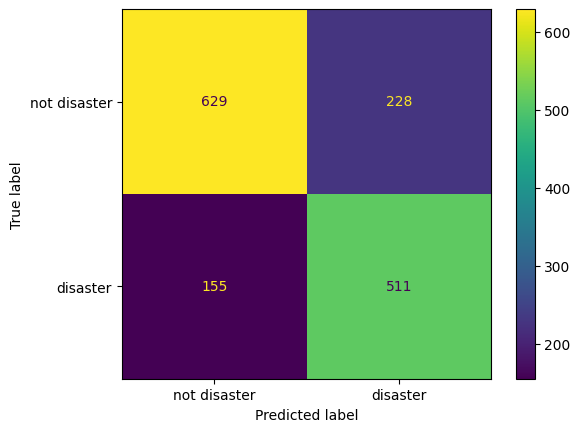

In [16]:
# Plot the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix( np.argmax( test_y , axis=1 ) ,np.argmax( pred_y , axis=1 ) )
disp = sklearn.metrics.ConfusionMatrixDisplay( conf_matrix , display_labels=[ 'not disaster' , 'disaster' ] )
disp.plot()

In [17]:
# Read the test.csv file
test_df = pd.read_csv('https://raw.githubusercontent.com/nikjohn7/Disaster-Tweets-Kaggle/main/data/test.csv', usecols=[ 'text' , 'id'])
# Clean, tokenize, pad the sentences from test_df
test_inputs = []
for text in test_df[ 'text' ].values:
    tokens = process_sent( text )
    out = sent_to_int_seq( tokens )
    out = pad_sequence( out , maxlen )
    test_inputs.append( out )

# Fetch predictions for test_inputs
test_inputs = np.array( test_inputs )
predicted_labels = np.argmax( model.predict( test_inputs ) , axis=1 )

ids = test_df[ 'id' ].values

# Create the output.csv file from ids and predicted_labels
output_csv = { 'id' : ids , 'target' : predicted_labels }
output_csv = pd.DataFrame.from_dict(output_csv)
output_csv.to_csv('output.csv', index=False )

102/102 [==============================] - 1s 11ms/step
